In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Load the SED - here I am using a template S0 galaxy SED from SWIRE
sed_file = "S0_template_norm.sed"
sed_data = pd.read_csv(sed_file, delim_whitespace=True, names=['wavelength', 'flux'])

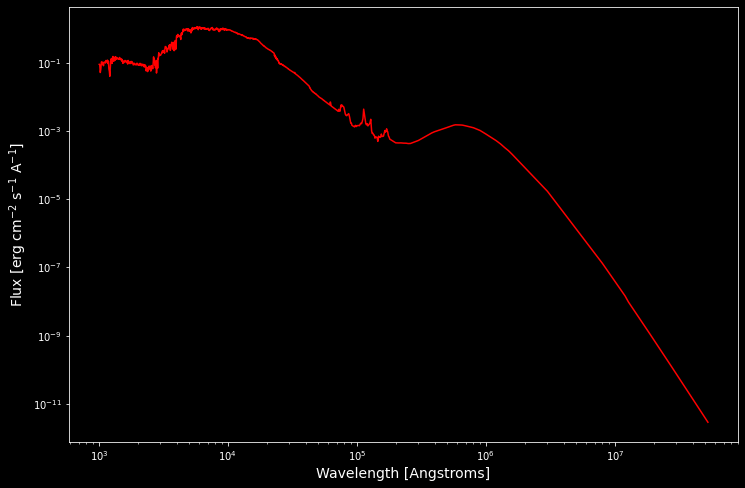

In [3]:
# Inspect the SED
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))
plt.plot(sed_data['wavelength'], sed_data['flux'], color='red')
plt.xlabel('Wavelength [Angstroms]', fontsize=14)
plt.ylabel(r'Flux [erg cm$^{-2}$ s$^{-1}$ A$^{-1}$]', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [4]:
# Attenuation via Calzetti+ 2000

def apply_dust_attenuation(wavelength, flux, Av=0.5, Rv=4.05):
    # Calzetti attenuation law is defined using microns
    lam_microns = wavelength / 1e4
    # Calzetti attenuation curve
    k = np.where(lam_microns <= 0.63, 
                 2.659 * (-2.156 + 1.509/lam_microns - 0.198/lam_microns**2 + 0.011/lam_microns**3) + Rv, 
                 2.659 * (-1.857 + 1.040/lam_microns) + Rv)
    attenuation_factor = 10**(-0.4 * Av * k / Rv)
    return flux * attenuation_factor

In [5]:
# Dust emission via blackbody
def add_dust_emission(wavelength, flux, dust_temp=30.0, scaling_factor=1e-2): # 30K is mid-range between cold and hot dust
    lam_meters = wavelength * 1e-10  # mks
    h = 6.626e-34
    c = 3.0e8
    k = 1.38e-23
    # Blackbody emission
    B_lam = (2.0 * h * c**2 / lam_meters**5) / (np.exp(h * c / (lam_meters * k * dust_temp)) - 1.0)
    emission_flux = flux + scaling_factor * B_lam
    return emission_flux

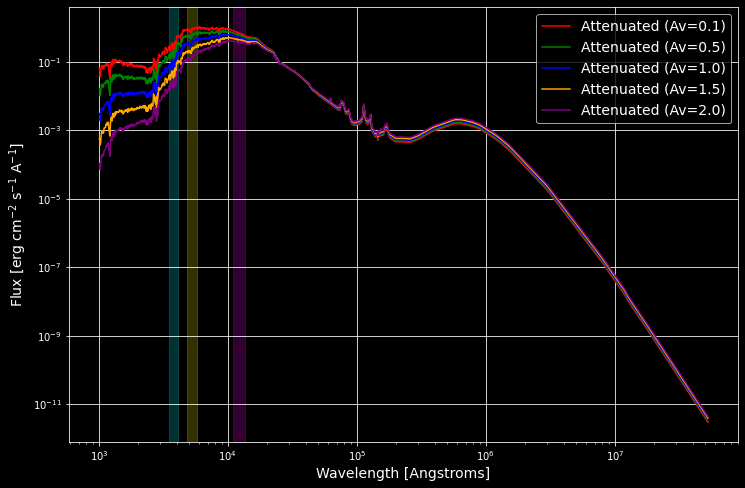

In [6]:
# Plot original and attenuated SEDs
plt.figure(figsize=(12, 8))
Av_values = [0.1, 0.5, 1.0, 1.5, 2.0]  # Bunch of Av values to try
colors = ['red', 'green', 'blue', 'orange', 'purple']
attenuated_fluxes = []

for Av, color in zip(Av_values, colors):
    attenuated_flux = apply_dust_attenuation(sed_data['wavelength'], sed_data['flux'], Av=Av)
    attenuated_fluxes.append(attenuated_flux)  # Store for later use
    plt.plot(sed_data['wavelength'], attenuated_flux, label=f'Attenuated (Av={Av})', color=color)

# I've added some bands for reference
plt.axvspan(3500, 4100, color='cyan', alpha=0.2) # close enough to U
plt.axvspan(4800, 5800, color='yellow', alpha=0.2) # close enough to V
plt.axvspan(11000, 13500, color='magenta', alpha=0.2) # close enough to J
plt.legend(fontsize=14, loc='upper right')
plt.xlabel('Wavelength [Angstroms]', fontsize=14)
plt.ylabel(r'Flux [erg cm$^{-2}$ s$^{-1}$ A$^{-1}$]', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

In [7]:
# Let's dump all the attenuated SEDs to a single file
output_file = "S0_template_attenuated.sed"
with open(output_file, 'w') as file:
    file.write("# Wavelength (Angstroms) Flux (erg cm^-2 s^-1 A^-1)\n")
    for i, Av in enumerate(Av_values):
        file.write(f"# Attenuated SED (Av={Av})\n")
        for wavelength, flux in zip(sed_data['wavelength'], attenuated_fluxes[i]):
            file.write(f"{wavelength:.2f} {flux:.6e}\n") 

print(f"Successfully saved attenuated SEDs to {output_file}")

Successfully saved attenuated SEDs to S0_template_attenuated.sed
